## **1. What is Feature Engineering**

In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

df = pd.read_csv("../Data/concrete.csv")
df.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [4]:
X = df.drop(columns=['CompressiveStrength'])
y = df['CompressiveStrength']

baseline = RandomForestRegressor(criterion = 'absolute_error', random_state = 42)
baseline_score = cross_val_score(
    baseline, X, y, cv = 5, scoring = 'neg_mean_absolute_error'
)
baseline_score_mean = -1 * baseline_score.mean()

print(f"MAE Baseline Score: {baseline_score_mean:.4f}")

MAE Baseline Score: 8.3761


In [6]:
X = df.drop(columns=['CompressiveStrength'])
y = df['CompressiveStrength']

X['FCRatio'] = X['FineAggregate'] / X['CoarseAggregate']
X['AggCmtRatio'] = (X['CoarseAggregate'] + X['FineAggregate']) / X['Cement']
X['WtrCmtRatio'] = X['Water'] / X['Cement']

model = RandomForestRegressor(criterion = 'absolute_error', random_state = 42)
score = cross_val_score(model, X, y, cv = 5, scoring = 'neg_mean_absolute_error')

score_mean = -1 * score.mean()

print(f"MAE Score with Ratio Features: {score_mean:.4f}")

MAE Score with Ratio Features: 7.8487


## **2. Mutual Information**

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')

df = pd.read_csv('../Data/autos.csv')

df.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


In [15]:
X = df.drop(columns = ['price'])
y = df['price']

# Label encoding for categoricals
for colname in X.select_dtypes('object'):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [25]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features = discrete_features)
    mi_scores = pd.Series(mi_scores, name = 'MI Scores', index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)

mi_scores[::3]

curb_weight          0.914499
highway_mpg          0.863971
length               0.611757
fuel_system          0.464485
drive_wheels         0.333404
symboling            0.233674
compression_ratio    0.108900
fuel_type            0.048139
Name: MI Scores, dtype: float64

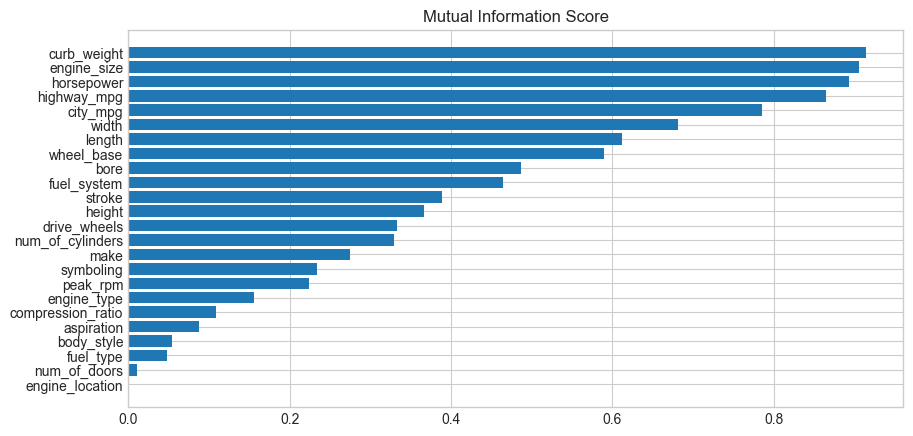

In [27]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Score")

plt.figure(dpi = 100, figsize = (10, 5))
plot_mi_scores(mi_scores)

<Figure size 1152x360 with 0 Axes>

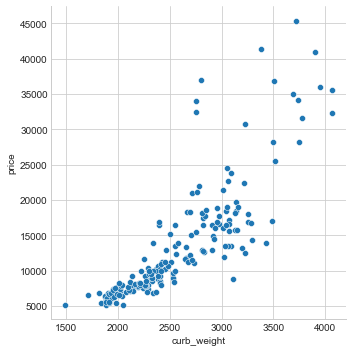

In [29]:
sns.relplot(x = 'curb_weight', y = 'price', data = df)

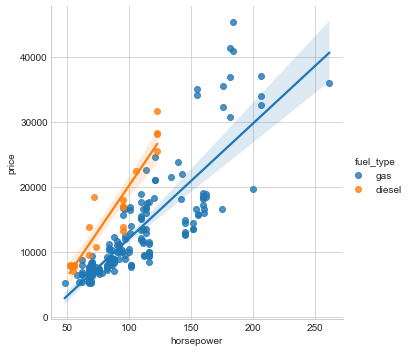

In [31]:
sns.lmplot(x = 'horsepower', y = 'price', hue = 'fuel_type', data = df)

## **3. Creating Features**

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
plt.rc('figure', autolayout = True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

accidents = pd.read_csv('../Data/accidents.csv')
autos = pd.read_csv("../Data/autos.csv")
concrete = pd.read_csv("../Data/concrete.csv")
customer = pd.read_csv("../Data/customer.csv")

### Mathematical Transform

In [36]:
autos['stroke_ratio'] = autos['stroke'] / autos['bore']

autos[['stroke_ratio', 'stroke', 'bore']].head()

,stroke_ratio,stroke,bore
0,0.772334,2.68,3.47
1,0.772334,2.68,3.47
2,1.294776,3.47,2.68
3,1.065831,3.40,3.19
4,1.065831,3.40,3.19


In [37]:
autos['displacement'] = (
    np.pi * ((0.5 * autos['bore']) ** 2) * autos['stroke'] * autos['num_of_cylinders']
)

C:\Users\LENOVO\AppData\Local\Temp/ipykernel_9256/2207568274.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(accidents['WindSpeed'], shade = True, ax = axs[0])
C:\Users\LENOVO\AppData\Local\Temp/ipykernel_9256/2207568274.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(accidents['LogWindSpeed'], shade = True, ax = axs[1])


<Axes: xlabel='LogWindSpeed', ylabel='Density'>

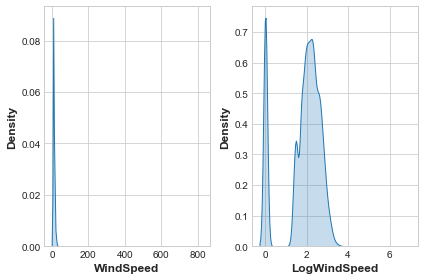

In [38]:
# If the feature has 0.0 values, use np.log1p (log(1+x)) instead of np.log
accidents["LogWindSpeed"] = accidents.WindSpeed.apply(np.log1p)

# Plot a comparison
fig, axs = plt.subplots(1, 2, figsize = (6, 4))
sns.kdeplot(accidents['WindSpeed'], shade = True, ax = axs[0])
sns.kdeplot(accidents['LogWindSpeed'], shade = True, ax = axs[1])

### Counts

In [40]:
roadway_features = ["Amenity", "Bump", "Crossing", "GiveWay",
    "Junction", "NoExit", "Railway", "Roundabout", "Station", "Stop",
    "TrafficCalming", "TrafficSignal"]

accidents['RoadwayFeatures'] = accidents[roadway_features].sum(axis = 1)

accidents[roadway_features + ['RoadwayFeatures']].head(10)

,Amenity,Bump,Crossing,GiveWay,Junction,NoExit,Railway,Roundabout,Station,Stop,TrafficCalming,TrafficSignal,RoadwayFeatures
0,False,False,False,False,False,False,False,False,False,False,False,False,0
1,False,False,False,False,False,False,False,False,False,False,False,False,0
2,False,False,False,False,False,False,False,False,False,False,False,False,0
3,False,False,False,False,False,False,False,False,False,False,False,False,0
4,False,False,False,False,False,False,False,False,False,False,False,False,0
5,False,False,False,False,True,False,False,False,False,False,False,False,1
6,False,False,False,False,False,False,False,False,False,False,False,False,0
7,False,False,True,False,False,False,False,False,False,False,False,True,2
8,False,False,True,False,False,False,False,False,False,False,False,True,2
9,False,False,False,False,False,False,False,False,False,False,False,False,0


In [41]:
components = [ "Cement", "BlastFurnaceSlag", "FlyAsh", "Water",
               "Superplasticizer", "CoarseAggregate", "FineAggregate"]

concrete['Components'] = concrete[components].gt(0).sum(axis = 1)

concrete[components + ['Components']].head(10)

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Components
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,5
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,5
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,5
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,4


### Building-Up and Breaking-Down Features

In [43]:
customer[['Type', 'Level']] = (customer['Policy'].str.split(" ", expand = True))

customer[['Type', 'Level', 'Policy']].head(10)

,Type,Level,Policy
0,Corporate,L3,Corporate L3
1,Personal,L3,Personal L3
2,Personal,L3,Personal L3
3,Corporate,L2,Corporate L2
4,Personal,L1,Personal L1
5,Personal,L3,Personal L3
6,Corporate,L3,Corporate L3
7,Corporate,L3,Corporate L3
8,Corporate,L3,Corporate L3
9,Special,L2,Special L2


In [44]:
autos['make_and_style'] = autos['make'] + "_" + autos['body_style']

autos[['make', 'body_style', 'make_and_style']].head(10)

,make,body_style,make_and_style
0,alfa-romero,convertible,alfa-romero_convertible
1,alfa-romero,convertible,alfa-romero_convertible
2,alfa-romero,hatchback,alfa-romero_hatchback
3,audi,sedan,audi_sedan
4,audi,sedan,audi_sedan
5,audi,sedan,audi_sedan
6,audi,sedan,audi_sedan
7,audi,wagon,audi_wagon
8,audi,sedan,audi_sedan
9,bmw,sedan,bmw_sedan


### Group Transforms

In [52]:
customer['AverageIncome'] = customer.groupby('State')['Income'].transform('mean')

customer[['State', 'Income', 'AverageIncome']].head(10)

,State,Income,AverageIncome
0,Washington,56274,38122.733083
1,Arizona,0,37405.402231
2,Nevada,48767,38369.605442
3,California,0,37558.946667
4,Washington,43836,38122.733083
5,Oregon,62902,37557.283353
6,Oregon,55350,37557.283353
7,Arizona,0,37405.402231
8,Oregon,14072,37557.283353
9,Oregon,28812,37557.283353


In [55]:
customer['StateFreq'] = customer.groupby('State')['State'].transform('count') / customer['State'].count()

customer[['State', 'StateFreq']].head(10)

,State,StateFreq
0,Washington,0.087366
1,Arizona,0.186446
2,Nevada,0.096562
3,California,0.344865
4,Washington,0.087366
5,Oregon,0.284760
6,Oregon,0.284760
7,Arizona,0.186446
8,Oregon,0.284760
9,Oregon,0.284760


In [62]:
df_train = customer.sample(frac = 0.5)
df_valid = customer.drop(df_train.index)

# Create the average claim amount by coverage type, on the training set
df_train['AverageClaim'] = df_train.groupby('Coverage')['ClaimAmount'].transform('mean')

# Merge the values into the validation set
df_valid = df_valid.merge(df_train[['Coverage', 'AverageClaim']].drop_duplicates(), on = 'Coverage', how = 'left')

df_valid[['Coverage', 'AverageClaim']].head(10)

,Coverage,AverageClaim
0,Basic,378.336452
1,Extended,475.870908
2,Premium,670.921419
3,Basic,378.336452
4,Basic,378.336452
5,Basic,378.336452
6,Basic,378.336452
7,Basic,378.336452
8,Extended,475.870908
9,Basic,378.336452


## **4. Clustering with K-Means**

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

plt.style.use('seaborn-v0_8-whitegrid')
plt.rc('figure', autolayout = True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

df = pd.read_csv('../Data/housing.csv')
X = df.loc[:, ['MedInc', 'Latitude', 'Longitude']]

X.head()

,MedInc,Latitude,Longitude
0,8.3252,37.88,-122.23
1,8.3014,37.86,-122.22
2,7.2574,37.85,-122.24
3,5.6431,37.85,-122.25
4,3.8462,37.85,-122.25


In [71]:
# Create cluster feature
kmeans = KMeans(n_clusters = 6)
X['Cluster'] = kmeans.fit_predict(X)
X['Cluster'] = X['Cluster'].astype('category')

X.head()

,MedInc,Latitude,Longitude,Cluster
0,8.3252,37.88,-122.23,2
1,8.3014,37.86,-122.22,2
2,7.2574,37.85,-122.24,2
3,5.6431,37.85,-122.25,2
4,3.8462,37.85,-122.25,3


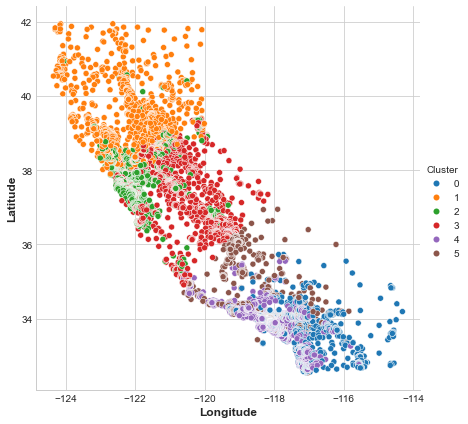

In [73]:
sns.relplot(x = 'Longitude', y = 'Latitude', data = X, hue = 'Cluster', height = 6)

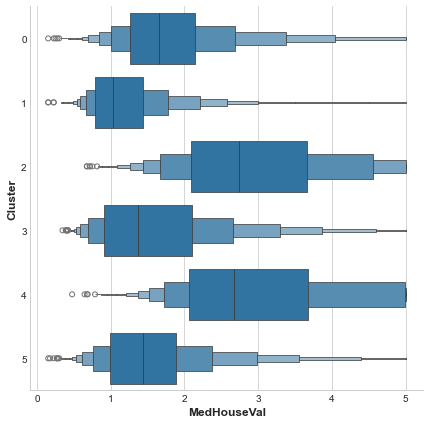

In [77]:
X['MedHouseVal'] = df['MedHouseVal']

sns.catplot(x = 'MedHouseVal', y = 'Cluster', data = X, kind = 'boxen', height = 6)

## **5. Principal Component Analysis**

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression


plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


df = pd.read_csv("../Data/autos.csv")

In [85]:
features = ['highway_mpg', 'engine_size', 'horsepower', 'curb_weight']

X = df.drop(columns = ['price'])
y= df['price']

X = X.loc[:, features]

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

In [88]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4
0,0.382486,-0.400222,0.124122,0.169539
1,0.382486,-0.400222,0.124122,0.169539
2,1.550890,-0.107175,0.598361,-0.256081
3,-0.408859,-0.425947,0.243335,0.013920
4,1.132749,-0.814565,-0.202885,0.224138


In [89]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4
highway_mpg,-0.492347,0.770892,0.070142,-0.397996
engine_size,0.503859,0.626709,0.019960,0.594107
horsepower,0.500448,0.013788,0.731093,-0.463534
curb_weight,0.503262,0.113008,-0.678369,-0.523232


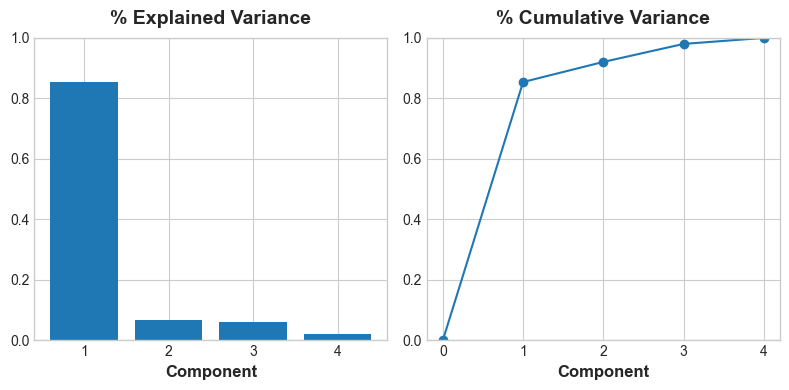

In [90]:
# Look at explained variance
plot_variance(pca);

In [91]:
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores

PC1    1.014010
PC2    0.380098
PC3    0.306797
PC4    0.204478
Name: MI Scores, dtype: float64

In [92]:
# Show dataframe sorted by PC3
idx = X_pca["PC3"].sort_values(ascending=False).index
cols = ["make", "body_style", "horsepower", "curb_weight"]
df.loc[idx, cols]

,make,body_style,horsepower,curb_weight
118,porsche,hardtop,207,2756
117,porsche,hardtop,207,2756
119,porsche,convertible,207,2800
45,jaguar,sedan,262,3950
96,nissan,hatchback,200,3139
...,...,...,...,...
59,mercedes-benz,wagon,123,3750
61,mercedes-benz,sedan,123,3770
101,peugot,wagon,95,3430
105,peugot,wagon,95,3485


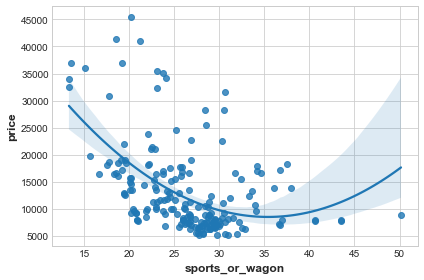

In [93]:
df["sports_or_wagon"] = X.curb_weight / X.horsepower
sns.regplot(x="sports_or_wagon", y='price', data=df, order=2);